# LSI and Scikit-Learn
    Ethan Crawford
    MAth 403
    10/17/23

In [1]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

(569, 2)


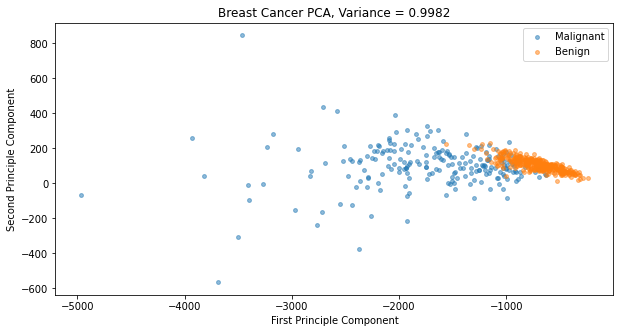

In [4]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    # Import data
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target
    
    # Translate the columns of X to have mean 0
    Y = X-np.mean(X, axis=0)

    # Compute truncated SVD
    U,E,Vh = la.svd(Y)
    X_hat = X@Vh.T[:,:2]

    # Plot
    plt.figure(figsize=(10,5))
    for data, name in zip([X_hat[y == 0], X_hat[y == 1]], ["Malignant", "Benign"]):
        plt.scatter(data[:,0], data[:,1], label=name, alpha=0.5, s = 15)

    plt.xlabel("First Principle Component")
    plt.ylabel("Second Principle Component")
    plt.title(f'Breast Cancer PCA, Variance = {round(sum(((E**2)/np.sum(E**2))[:2]), 4)}')
    plt.legend()
    plt.show()

prob1()

## Problem 2
Implement the function similar()

In [136]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    # Calculate the similarity values for all rows in Xhat
    similarities = np.dot(Xhat[i], Xhat.T)/(la.norm(Xhat[i])* la.norm(Xhat, axis=1))

    # Argsort the array to get the most similar and least similar
    similarities_sorted = np.argsort(similarities)

    # Return the most similar (other than itself) and least similar
    return similarities_sorted[0], similarities_sorted[-2]

In [137]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.  ],
    [0.64, 0.97, 0.  , 0.  ],
    [0.  , 0.  , 0.63, 0.46],
    [0.  , 0.84, 0.6 , 0.  ],
    [0.29, 0.89, 0.51, 0.  ],
    [0.77, 0.  , 0.27, 0.2 ],
    [0.86, 0.47, 0.  , 0.06],
    [0.89, 0.  , 0.  , 0.  ]
]) 
print(similar(4, X))

(7, 3)


### Function for Problem 3

In [138]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
              
    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [141]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # Get the word count matrix X and the list of speech paths
    X, paths = document_converter()

    # Compute truncated SVD
    U, E, Vh = spla.svds(X, l, random_state=28)
    Xhat = X @ Vh.T[:,:l]

    # Get the index of the speech
    speech_index = paths.index(speech)

    # Get the index of the most similar and least similar speeches
    index_min, index_max = similar(speech_index, Xhat)

    # Return the most similar and least similar speeches
    return paths[index_max][12:-4], paths[index_min][12:-4]

In [142]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [143]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get X and paths from unweighted document converter
    X, paths = document_converter()
    m, n = X.shape

    # Define p
    p = X / np.sum(X, axis=0)
    
    # Define global weight of the ith column
    g = 1 + np.sum(p*np.log(p+1), axis=0)/np.log(m)
    
    # Weight X by the column weights
    A = g * np.log1p(X)
    
    return A, paths

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [145]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # Get the word count matrix X and the list of speech paths
    X, paths = weighted_document_converter()

    # Compute truncated SVD
    U, E, Vh = spla.svds(X, l, random_state=74)
    Xhat = X @ Vh.T[:,:l]

    # Get the index of the speech
    speech_index = paths.index(speech)

    # Get the index of the most similar and least similar speeches
    index_min, index_max = similar(speech_index, Xhat)

    # Return the most similar and least similar speeches
    return paths[index_max][12:-4], paths[index_min][12:-4]

In [146]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('1992-Bush', '1946-Truman')
('1985-Reagan', '1946-Truman')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [122]:
# Import data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Run Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Run KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('Random Forest Classifier')
print(classification_report(y_test, y_pred_rf), '\n\n')
print('KNN Classifier')
print(classification_report(y_test, y_pred_knn))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143
 


KNN Classifier
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



The random forest classifier is better in all score categories, so we should use that one.

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [129]:
# Import data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Define model
rf = RandomForestClassifier()

# Specify values for certain hyperparameters
param_grid = {"max_depth": [2, 3, 4, 5],
              "min_samples_leaf": [2,3,4,5],
              'max_features': ['sqrt', 'log2']}

rf_gs = GridSearchCV(rf, param_grid, scoring="f1", n_jobs=-1)

# Run the actual search. This may take some time.
rf_gs.fit(X_train, y_train)

# After fitting, you can access data about the results.
print('Best Parameters:',rf_gs.best_params_, '\nBest Score:', rf_gs.best_score_, sep='\n')

# Predict
y_pred = rf_gs.predict(X_test)

# Print out confusion matrix
print('\nConfusion Matrix')
print(confusion_matrix(y_test, y_pred))

Best Parameters:
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2}

Best Score:
0.9724418496895562

Confusion Matrix
[[52  4]
 [ 4 83]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [133]:
# Create pipeline
pipe = Pipeline([("scale", StandardScaler()),
                 ("pca",PCA()),
                 ("knn",KNeighborsClassifier())])

# Define parameters
pipe_param_grid = {"scale__with_mean": [True, False],
                   "scale__with_std": [True, False],
                   "pca__n_components":[5,10,None,'mle'],
                   "pca__whiten":[True,False], 
                   "knn__n_neighbors": [2,3,4,5,6],
                   'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                   "knn__weights": ["uniform", "distance"]}

# Run grid search
pipe_gs = GridSearchCV(pipe, pipe_param_grid, n_jobs=-1).fit(X_train, y_train)

# Print best parameters
print('Best Parameters:')
pprint(pipe_gs.best_params_)
print('\nBest Score:', pipe_gs.best_score_, sep='\n')

Best Parameters:
{'knn__algorithm': 'auto',
 'knn__n_neighbors': 3,
 'knn__weights': 'uniform',
 'pca__n_components': 10,
 'pca__whiten': False,
 'scale__with_mean': True,
 'scale__with_std': True}

Best Score:
0.9718467852257182
